In [1]:
%%time
import pandas as pd
import numpy as np
from sklearn import cross_validation, ensemble, tree, metrics, preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
le = preprocessing.LabelEncoder()
import xgboost as xgb
from datetime import datetime
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

CPU times: user 1.17 s, sys: 450 ms, total: 1.62 s
Wall time: 3.64 s


In [28]:
%%time
temp_train_2014_1 = pd.read_csv('CAX_Train_2014_Jan_to_Jun.csv')
temp_train_2014_2 = pd.read_csv('CAX_Train_2014_Jul_to_Dec.csv')
temp_train_2015 = pd.read_csv('CAX_Train_2015.csv')
testing = pd.read_csv('CAX_TestSet.csv')
weather = pd.read_csv('weather.csv')
codes = pd.read_csv('training_weather_cities_joined.csv')

CPU times: user 54.6 s, sys: 15.2 s, total: 1min 9s
Wall time: 1min 15s


In [3]:
%%time
training = pd.concat([temp_train_2014_1, temp_train_2014_2, temp_train_2015], ignore_index=True)
training = pd.merge(training, codes[['ORIGIN', 'city', 'airport_code']], left_on='ORIGIN', right_on='ORIGIN')
training.rename(columns={'city': 'origin_city', 'airport_code': 'origin_icao_code'}, inplace=True)
training = pd.merge(training, codes[['ORIGIN', 'city', 'airport_code']], left_on='DEST', right_on='ORIGIN')
training.rename(columns={'city': 'dest_city', 'airport_code': 'dest_icao_code', 'ORIGIN_x': 'ORIGIN'}, inplace=True)
training = training.drop('ORIGIN_y', 1)
training['DAY_OF_YEAR'] = pd.to_datetime(training['FL_DATE'], errors='coerce').dt.dayofyear.astype(int)
# training['DAY_OF_YEAR'] = training['FL_DATE'].dt.dayofyear.astype(int)
delayed = training[training['ARR_DEL15'] == 1]
on_time = training[training['ARR_DEL15'] == 0]
sample_rows = np.random.choice(on_time.index.values, len(delayed))
on_time = on_time.ix[sample_rows]
training = pd.concat([on_time, delayed], ignore_index=True)

CPU times: user 49.7 s, sys: 23.8 s, total: 1min 13s
Wall time: 1min 18s


In [4]:
training.dtypes

id                    int64
YEAR                  int64
QUARTER               int64
MONTH                 int64
DAY_OF_MONTH          int64
DAY_OF_WEEK           int64
FL_DATE              object
UNIQUE_CARRIER       object
TAIL_NUM             object
FL_NUM                int64
ORIGIN               object
ORIGIN_AIRPORT_ID     int64
ORIGIN_CITY_NAME     object
ORIGIN_STATE_ABR     object
DEST                 object
DEST_AIRPORT_ID       int64
DEST_CITY_NAME       object
DEST_STATE_ABR       object
CRS_DEP_TIME          int64
DEP_TIME_BLK         object
TAXI_IN               int64
CRS_ARR_TIME          int64
ARR_TIME_BLK         object
ARR_DEL15             int64
CRS_ELAPSED_TIME      int64
DISTANCE              int64
DISTANCE_GROUP        int64
origin_city          object
origin_icao_code     object
dest_city            object
dest_icao_code       object
DAY_OF_YEAR           int64
dtype: object

In [5]:
%%time
training.UNIQUE_CARRIER = le.fit_transform(training.UNIQUE_CARRIER)
training.ORIGIN = le.fit_transform(training.ORIGIN)
training.origin_city = le.fit_transform(training.origin_city)
training.ORIGIN_STATE_ABR = le.fit_transform(training.ORIGIN_STATE_ABR)
training.DEST = le.fit_transform(training.DEST)
training.dest_city = le.fit_transform(training.dest_city)
training.DEST_STATE_ABR = le.fit_transform(training.DEST_STATE_ABR)
training.DEP_TIME_BLK = le.fit_transform(training.DEP_TIME_BLK)
training.ARR_TIME_BLK = le.fit_transform(training.ARR_TIME_BLK)
training.FL_DATE = le.fit_transform(training.FL_DATE)
training.TAIL_NUM = le.fit_transform(training.TAIL_NUM)
training.origin_icao_code = le.fit_transform(training.origin_icao_code)
training.dest_icao_code = le.fit_transform(training.dest_icao_code)

/Users/arkham/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


CPU times: user 47.4 s, sys: 805 ms, total: 48.2 s
Wall time: 48.2 s


In [6]:
training.dtypes

id                    int64
YEAR                  int64
QUARTER               int64
MONTH                 int64
DAY_OF_MONTH          int64
DAY_OF_WEEK           int64
FL_DATE               int64
UNIQUE_CARRIER        int64
TAIL_NUM              int64
FL_NUM                int64
ORIGIN                int64
ORIGIN_AIRPORT_ID     int64
ORIGIN_CITY_NAME     object
ORIGIN_STATE_ABR      int64
DEST                  int64
DEST_AIRPORT_ID       int64
DEST_CITY_NAME       object
DEST_STATE_ABR        int64
CRS_DEP_TIME          int64
DEP_TIME_BLK          int64
TAXI_IN               int64
CRS_ARR_TIME          int64
ARR_TIME_BLK          int64
ARR_DEL15             int64
CRS_ELAPSED_TIME      int64
DISTANCE              int64
DISTANCE_GROUP        int64
origin_city           int64
origin_icao_code      int64
dest_city             int64
dest_icao_code        int64
DAY_OF_YEAR           int64
dtype: object

In [7]:
%%time
features = [c for c in training.columns if c not in ['DEST_CITY_NAME', 'ARR_DEL15', 'id', 'ORIGIN_CITY_NAME']]

CPU times: user 56 µs, sys: 13 µs, total: 69 µs
Wall time: 62.9 µs


In [ ]:
# %%time
# orig_weather.columns = ['ORIG_DATE', 'ORIG_TIME', 'ORIG_TIME_BLK', 'ORIG_CITY', 'ORIG_STATE', 'ORIG_ZIP', 'ORIG_AIRPORT_CODE', 'ORIG_TIME_CST', 'ORIG_DATE_UTC', 'ORIG_TEMPERATURE_F', 'ORIG_DEW_POINT_F', 'ORIG_HUMIDITY', 'ORIG_SEA_LEVEL_PRESSURE_IN', 'ORIG_VISIBILITY_MPH', 'ORIG_WIND_DIRECTION', 'ORIG_WIND_SPEED_MPH', 'ORIG_GUST_SPEED_MPH', 'ORIG_PRECIPITATION_IN', 'ORIG_EVENTS', 'ORIG_CONDITIONS', 'ORIG_WIND_DIR_DEGREES']
# dep_weather.columns = ['DEST_DATE', 'DEST_TIME', 'DEST_TIME_BLK', 'DEST_CITY', 'DEST_STATE', 'DEST_ZIP', 'DEST_AIRPORT_CODE', 'DEST_TIME_CST', 'DEST_DATE_UTC', 'DEST_TEMPERATURE_F', 'DEST_DEW_POINT_F', 'DEST_HUMIDITY', 'DEST_SEA_LEVEL_PRESSURE_IN', 'DEST_VISIBILITY_MPH', 'DEST_WIND_DIRECTION', 'DEST_WIND_SPEED_MPH', 'DEST_GUST_SPEED_MPH', 'DEST_PRECIPITATION_IN', 'DEST_EVENTS', 'DEST_CONDITIONS', 'DEST_WIND_DIR_DEGREES']

In [ ]:
%%time
test_weather = pd.merge(orig_weather, codes[['gps_code', 'iata_code']], left_on='ORIG_AIRPORT_CODE', right_on='gps_code')
#arr_weather = pd.merge(orig_weather, codes[['gps_code', 'local_code']], left_on='ORIG_AIRPORT_CODE', right_on='gps_code')
#dep_weather = pd.merge(dest_weather, codes[['gps_code', 'local_code']], left_on='DEST_AIRPORT_CODE', right_on='gps_code')

In [ ]:
# %%time
# training_ww = pd.merge(training, test_weather, left_on=['FL_DATE', 'ORIGIN','ARR_TIME_BLK'], right_on=['ARR_DATE', 'local_code', 'ARR_TIME_BLK'])
# training_ww = pd.merge(training_ww, dep_weather, left_on=['FL_DATE', 'DEST','DEP_TIME_BLK'], right_on=['DEP_DATE', 'local_code', 'DEP_TIME_BLK'])

In [ ]:
# origin_state = pd.DataFrame(training.ORIGIN_STATE_ABR.drop_duplicates())
# dest_state = pd.DataFrame(training.DEST_STATE_ABR.drop_duplicates())
# print len(origin_state), len(dest_state)

In [ ]:
# arr_codes = arr_weather.ARR_AIRPORT_CODE.drop_duplicates()

In [ ]:
# %%time
# training_nw = training[~(training.id.isin(training_ww.id))]

In [ ]:
# print len(training), (len(training_ww) + len(training_nw))

In [ ]:
# %%time
# with_dest_match = pd.merge(all_train, destinations_df)

In [8]:
%%time
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(training[features], training['ARR_DEL15'], test_size=0.50)
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features_train, labels_train, test_size=0.50)
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features_train, labels_train, test_size=0.40)

CPU times: user 8.56 s, sys: 3.33 s, total: 11.9 s
Wall time: 12.6 s


In [9]:
%%time
def modelfit(alg, features, labels, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(features.values, label=labels.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['auc'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(features, labels, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(features)
    dtrain_predprob = alg.predict_proba(features)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(labels.values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(labels, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 8.82 µs
Parser   : 128 ms


Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 121



Model Report
Accuracy : 0.6858
AUC Score (Train): 0.754404


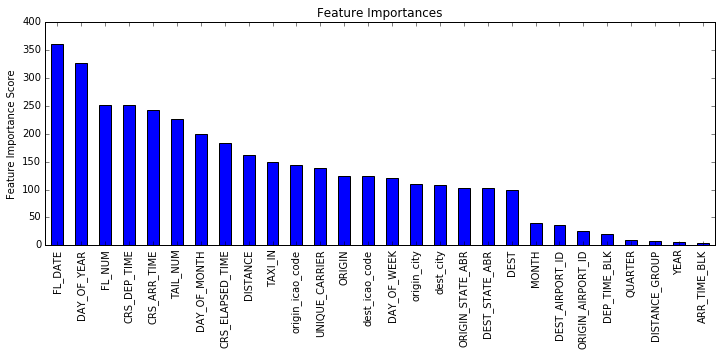

In [10]:
xgb1 = xgb.XGBClassifier(
 learning_rate = 1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, features_train, labels_train)

In [11]:
%%time
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =1, n_estimators=121, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(features_train.values, labels_train.values)
print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view 

[mean: 0.71492, std: 0.00128, params: {'max_depth': 3, 'min_child_weight': 1}, mean: 0.71512, std: 0.00115, params: {'max_depth': 3, 'min_child_weight': 3}, mean: 0.71511, std: 0.00147, params: {'max_depth': 3, 'min_child_weight': 5}, mean: 0.71706, std: 0.00095, params: {'max_depth': 5, 'min_child_weight': 1}, mean: 0.71714, std: 0.00087, params: {'max_depth': 5, 'min_child_weight': 3}, mean: 0.71751, std: 0.00144, params: {'max_depth': 5, 'min_child_weight': 5}, mean: 0.70371, std: 0.00181, params: {'max_depth': 7, 'min_child_weight': 1}, mean: 0.70466, std: 0.00191, params: {'max_depth': 7, 'min_child_weight': 3}, mean: 0.70528, std: 0.00103, params: {'max_depth': 7, 'min_child_weight': 5}, mean: 0.68656, std: 0.00101, params: {'max_depth': 9, 'min_child_weight': 1}, mean: 0.68988, std: 0.00092, params: {'max_depth': 9, 'min_child_weight': 3}, mean: 0.69156, std: 0.00220, params: {'max_depth': 9, 'min_child_weight': 5}] {'max_depth': 5, 'min_child_weight': 5} 0.71750678968
CPU times

In [17]:
%%time
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =1, n_estimators=121, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(features_train.values, labels_train.values)
print gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view 

[mean: 0.71718, std: 0.00079, params: {'max_depth': 4, 'min_child_weight': 4}, mean: 0.71799, std: 0.00116, params: {'max_depth': 4, 'min_child_weight': 5}, mean: 0.71819, std: 0.00128, params: {'max_depth': 4, 'min_child_weight': 6}, mean: 0.71739, std: 0.00121, params: {'max_depth': 5, 'min_child_weight': 4}, mean: 0.71751, std: 0.00144, params: {'max_depth': 5, 'min_child_weight': 5}, mean: 0.71711, std: 0.00094, params: {'max_depth': 5, 'min_child_weight': 6}, mean: 0.71230, std: 0.00121, params: {'max_depth': 6, 'min_child_weight': 4}, mean: 0.71283, std: 0.00104, params: {'max_depth': 6, 'min_child_weight': 5}, mean: 0.71260, std: 0.00155, params: {'max_depth': 6, 'min_child_weight': 6}] {'max_depth': 4, 'min_child_weight': 6} 0.718186910002
CPU times: user 1min 59s, sys: 1.56 s, total: 2min 1s
Wall time: 53min 28s


In [18]:
%%time
param_test2b = {
 'min_child_weight':[6,7,8]
}
gsearch2b = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=1, n_estimators=137, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(features_train.values, labels_train.values)
print gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view 

[mean: 0.71884, std: 0.00129, params: {'min_child_weight': 6}, mean: 0.71886, std: 0.00113, params: {'min_child_weight': 7}, mean: 0.71859, std: 0.00177, params: {'min_child_weight': 8}] {'min_child_weight': 7} 0.718859346724
CPU times: user 2min 5s, sys: 939 ms, total: 2min 6s
Wall time: 17min 31s


In [19]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=1, n_estimators=137, max_depth=4,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(features_train.values, labels_train.values)
print gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view 

[mean: 0.71886, std: 0.00113, params: {'gamma': 0.0}, mean: 0.71876, std: 0.00123, params: {'gamma': 0.1}, mean: 0.71876, std: 0.00123, params: {'gamma': 0.2}, mean: 0.71876, std: 0.00123, params: {'gamma': 0.3}, mean: 0.71876, std: 0.00123, params: {'gamma': 0.4}] {'gamma': 0.0} 0.718859346724


Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 255



Model Report
Accuracy : 0.6856
AUC Score (Train): 0.753632
CPU times: user 28min 49s, sys: 4.24 s, total: 28min 53s
Wall time: 28min 54s


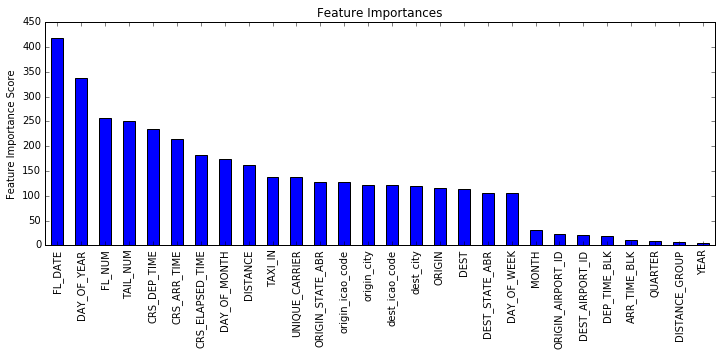

In [20]:
%%time
xgb2 = xgb.XGBClassifier(
 learning_rate =1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=7,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, features_train, labels_train)

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=1, n_estimators=255, max_depth=4,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(features_train.values, labels_train.values)
print gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(85,95,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=1, n_estimators=158, max_depth=5,
 min_child_weight=2, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(features_train.values, labels_train.values)
print gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
%%time
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=1, n_estimators=158, max_depth=5,
 min_child_weight=2, gamma=0.1, subsample=0.9, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(features_train.values, labels_train.values)
print gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
%%time
param_test7 = {
 'reg_alpha':[0.9, 0.95, 1, 1.05, 1.1]
}

gsearch7 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=1, n_estimators=158, max_depth=5,
 min_child_weight=2, gamma=0.1, subsample=0.9, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(features_train.values, labels_train.values)
print gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

In [ ]:
%%time
xgb3 = xgb.XGBClassifier(
 learning_rate=1,
 n_estimators=1000,
 max_depth=5,
 reg_alpha=100,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, features_train, labels_train)

In [ ]:
%%time
xgb4 = xgb.XGBClassifier(
 learning_rate=.5,
 n_estimators=5000,
 max_depth=5,
 reg_alpha=100,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, features_train, labels_train)

In [22]:
%%time
xgb_final =  xgb.XGBClassifier(
 learning_rate = 1,
 n_estimators=122,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27).fit(features_train.values, labels_train.values)

CPU times: user 2min 14s, sys: 413 ms, total: 2min 15s
Wall time: 2min 15s


In [23]:
%%time
pred = xgb_final.predict(features_test.values)

CPU times: user 2.58 s, sys: 186 ms, total: 2.77 s
Wall time: 2.78 s


In [24]:
%%time
#fpr, tpr, thresholds = metrics.roc_curve(labels_test.values, pred)
print metrics.roc_auc_score(labels_test.values, pred)
# print metrics.accuracy_score(pred, labels_test)

0.66130981511
CPU times: user 46.5 ms, sys: 15.2 ms, total: 61.7 ms
Wall time: 62.6 ms


In [29]:
%%time
testing = pd.merge(testing, codes[['ORIGIN', 'city', 'airport_code']], left_on='ORIGIN', right_on='ORIGIN')
testing.rename(columns={'city': 'origin_city', 'airport_code': 'origin_icao_code'}, inplace=True)
testing = pd.merge(testing, codes[['ORIGIN', 'city', 'airport_code']], left_on='DEST', right_on='ORIGIN')
testing.rename(columns={'city': 'dest_city', 'airport_code': 'dest_icao_code', 'ORIGIN_x': 'ORIGIN'}, inplace=True)
testing = testing.drop('ORIGIN_y', 1)
testing['DAY_OF_YEAR'] = pd.to_datetime(testing['FL_DATE'], errors='coerce').dt.dayofyear.astype(int)

CPU times: user 3.44 s, sys: 1.56 s, total: 5 s
Wall time: 5.02 s


In [30]:
%%time
testing.UNIQUE_CARRIER = le.fit_transform(testing.UNIQUE_CARRIER)
testing.ORIGIN = le.fit_transform(testing.ORIGIN)
testing.origin_city = le.fit_transform(testing.origin_city)
testing.ORIGIN_STATE_ABR = le.fit_transform(testing.ORIGIN_STATE_ABR)
testing.DEST = le.fit_transform(testing.DEST)
testing.dest_city = le.fit_transform(testing.dest_city)
testing.DEST_STATE_ABR = le.fit_transform(testing.DEST_STATE_ABR)
testing.DEP_TIME_BLK = le.fit_transform(testing.DEP_TIME_BLK)
testing.ARR_TIME_BLK = le.fit_transform(testing.ARR_TIME_BLK)
testing.FL_DATE = le.fit_transform(testing.FL_DATE)
testing.TAIL_NUM = le.fit_transform(testing.TAIL_NUM)
testing.origin_icao_code = le.fit_transform(testing.origin_icao_code)
testing.dest_icao_code = le.fit_transform(testing.dest_icao_code)

CPU times: user 14.1 s, sys: 591 ms, total: 14.7 s
Wall time: 14.7 s


In [31]:
%%time
test_pred = xgb_final.predict(testing[features].values)

CPU times: user 7.71 s, sys: 944 ms, total: 8.66 s
Wall time: 8.71 s


In [32]:
%%time
submission = pd.DataFrame()
submission['id'] = testing['id']
submission['ARR_DEL15'] = test_pred

CPU times: user 95.1 ms, sys: 23.9 ms, total: 119 ms
Wall time: 118 ms


In [33]:
%%time
submission.to_csv('submission.csv', index=False)

CPU times: user 1.29 s, sys: 27.8 ms, total: 1.31 s
Wall time: 1.44 s


In [ ]:
test_hour = [str((i/100) * 100) if (i % 100) < 50 else str((i/100) * 100 + 100) for i in training['CRS_DEP_TIME'].values]

In [ ]:
%%time
training['DEP_HOUR'] = [str((i/100) * 100) if (i % 100) < 30 else str((i/100) * 100 + 100) for i in training['CRS_DEP_TIME'].values]
training['ARR_HOUR'] = [str((i/100) * 100) if (i % 100) < 30 else str((i/100) * 100 + 100) for i in training['CRS_ARR_TIME'].values]